In [1]:
import transformer_lens
from IPython import get_ipython
import torch
import torch.nn as nn
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import plotly.express as px
from jaxtyping import Float
from circuitsvis.tokens import colored_tokens

from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities


ip = get_ipython()
if not ip.extension_manager.loaded:
    ip.extension_manager.load('autoreload')
    %autoreload 2

# Load a model (eg GPT-2 Small)
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-small")



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/vol/bitbucket/dm2223/attention-head-synergy/venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/vol/bitbucket/dm2223/attention-head-synergy/venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app

Loaded pretrained model gpt2-small into HookedTransformer


## step 1
Get the prompts that we will pass to the transformers to get their residual streams ideally with some consistent stable feature for example 200 pronmpts all in Spanish
Could make them all 10 tokens long by getting gpt4o to generate some shit then tokenize and slice at the relevant location

*** actually we probably want to make some much longer single string to learn a stable feature over, eg a single 3000 token spanish text

## step 2
Make a function that returns the residual streams at each token pos at some layer, should be shape \[prompt_token_len, hidden_dim\] and we should have like 300 of them?

## step 3 
init a trainable linear probe

## step 4
come up with a loss function that takes in the feature values as found by probe. Perhaps a first pass at this could be l1/2/3 (whatever encourages high but consistent feature values the best) between adjacent feature values.
Better losses could somehow find the loss by considering the similarity of 5 feature values.

## Step 5 
Interp


In [2]:
class linear_probe(nn.Module):
    def __init__(self, resid_width):
        super().__init__()
        self.linear = nn.Linear(resid_width, 1)
    
    def forward(self, x):
        return self.linear(x)
    


def stable_feature_loss(batch, activation_coef = 0):
    # Ensure the batch is a 2D tensor with shape [batch_size, 1]
    if len(batch.shape) != 2 or batch.shape[1] != 1:
        raise ValueError("Input batch must have shape [batch_size, 1]")
    
    batch = batch[1:]
    
    # Compute the differences between adjacent entries
    differences = batch[1:] - batch[:-1]
    
    # Compute the L2 norm of the differences
    l2_norms = torch.norm(differences, p=2, dim=1)

    # subtract the average of the feature activations to the loss
    loss = torch.sum(l2_norms) - activation_coef * torch.mean(batch)

    return loss
    
    
def train_probe_on_residuals(resid_activations, activation_coef = 0):

    probe = linear_probe(768).to('cuda')
    optimizer = torch.optim.Adam(probe.parameters(), lr=1e-3)

    losses = []
    for i in tqdm.trange(1000):
        probe.zero_grad()
        output = probe(resid_activations)
        loss = stable_feature_loss(output, activation_coef)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # normalize the probe weights
        with torch.no_grad():
            probe.linear.weight /= torch.norm(probe.linear.weight, p=2)
        
    return probe, losses


def string_to_residual_stream(
    string: str,
    model: transformer_lens.HookedTransformer,
    layer_index: int,
) -> Float[torch.Tensor, "pos d_model"]:
    """
    Takes in a prompt, breaks it into tokens, and returns all the residual activations along token positions
    """
    
    tokens = model.to_tokens(string)

    _, cache = model.run_with_cache(tokens, remove_batch_dim=True)

    resid_activations = cache[f"blocks.{layer_index}.hook_resid_pre"]

    # delete all unused variables
    del cache
    del tokens
    # clear the cache
    torch.cuda.empty_cache()

    return resid_activations

def vis_probe_activations_on_random_tokens(
    len_random_tokens: int,
    model: transformer_lens.HookedTransformer,
    layer_index: int,
    probe: nn.Module,
    include_special_tokens: bool = False,
):
    random_tokens = torch.randint(0, 50256, (1, len_random_tokens))
    random_string = model.to_string(random_tokens)[0]
    resid_random = string_to_residual_stream(random_string, model, layer_index=layer_index)
    feature_values_for_random_tokens = list(probe(resid_random).detach().cpu())
    feature_values_for_random_tokens = [x.item() for x in feature_values_for_random_tokens]

    # get the string tokens for visualization
    random_tokens_as_strs = model.to_str_tokens(random_string)

    if not include_special_tokens:
        random_tokens_as_strs = random_tokens_as_strs[1:]
        feature_values_for_random_tokens = feature_values_for_random_tokens[1:]

    return colored_tokens(tokens=random_tokens_as_strs, values=feature_values_for_random_tokens)


def vis_probe_activations_on_string(
    string: str,
    model: transformer_lens.HookedTransformer,
    layer_index: int,
    probe: nn.Module,
    include_special_tokens: bool = False,
):
    resid_activations = string_to_residual_stream(string, model, layer_index=layer_index)
    feature_values = list(probe(resid_activations).detach().cpu())
    feature_values = [x.item() for x in feature_values]

    # get the string tokens for visualization
    tokens_as_strs = model.to_str_tokens(string)

    if not include_special_tokens:
        tokens_as_strs = tokens_as_strs[1:]
        feature_values = feature_values[1:]

    return colored_tokens(tokens=tokens_as_strs, values=feature_values)



    
    




In [3]:
econ_text = """Economics (/ˌɛkəˈnɒmɪks, ˌiːkə-/)[1][2] is a social science that studies the production, distribution, and consumption of goods and services.[3][4]

Economics focuses on the behaviour and interactions of economic agents and how economies work. Microeconomics analyses what is viewed as basic elements within economies, including individual agents and markets, their interactions, and the outcomes of interactions. Individual agents may include, for example, households, firms, buyers, and sellers. Macroeconomics analyses economies as systems where production, distribution, consumption, savings, and investment expenditure interact, and factors affecting it: factors of production, such as labour, capital, land, and enterprise, inflation, economic growth, and public policies that have impact on these elements. It also seeks to analyse and describe the global economy.

Other broad distinctions within economics include those between positive economics, describing "what is", and normative economics, advocating "what ought to be";[5] between economic theory and applied economics; between rational and behavioural economics; and between mainstream economics and heterodox economics.[6]

Economic analysis can be applied throughout society, including business,[7] finance, cybersecurity,[8] health care,[9] engineering[10] and government.[11] It is also applied to such diverse subjects as crime,[12] education,[13] the family,[14] feminism,[15] law,[16] philosophy,[17] politics, religion,[18] social institutions, war,[19] science[20] and the environment.[21]

Definitions of economics

Main article: Definitions of economics
The earlier term for the discipline was 'political economy', but since the late 19th century, it has commonly been called 'economics'.[22] The term is ultimately derived from Ancient Greek οἰκονομία (oikonomia) which is a term for the "way (nomos) to run a household (oikos)", or in other words the know-how of an οἰκονομικός (oikonomikos), or "household or homestead manager". Derived terms such as "economy" can therefore often mean "frugal" or "thrifty".[23][24][25][26] By extension then, "political economy" was the way to manage a polis or state.

There are a variety of modern definitions of economics; some reflect evolving views of the subject or different views among economists.[27][28] Scottish philosopher Adam Smith (1776) defined what was then called political economy as "an inquiry into the nature and causes of the wealth of nations", in particular as:

a branch of the science of a statesman or legislator [with the twofold objectives of providing] a plentiful revenue or subsistence for the people ... [and] to supply the state or commonwealth with a revenue for the publick services.[29]

Jean-Baptiste Say (1803), distinguishing the subject matter from its public-policy uses, defined it as the science of production, distribution, and consumption of wealth.[30] On the satirical side, Thomas Carlyle (1849) coined "the dismal science" as an epithet for classical economics, in this context, commonly linked to the pessimistic analysis of Malthus (1798).[31] John Stuart Mill (1844) delimited the subject matter further:

The science which traces the laws of such of the phenomena of society as arise from the combined operations of mankind for the production of wealth, in so far as those phenomena are not modified by the pursuit of any other object.[32]

Alfred Marshall provided a still widely cited definition in his textbook Principles of Economics (1890) that extended analysis beyond wealth and from the societal to the microeconomic level:

Economics is a study of man in the ordinary business of life. It enquires how he gets his income and how he uses it. Thus, it is on the one side, the study of wealth and on the other and more important side, a part of the study of man.[33]

Lionel Robbins (1932) developed implications of what has been termed "[p]erhaps the most commonly accepted current definition of the subject":[28]

Economics is the science which studies human behaviour as a relationship between ends and scarce means which have alternative uses.[34]

Robbins described the definition as not classificatory in "pick[ing] out certain kinds of behaviour" but rather analytical in "focus[ing] attention on a particular aspect of behaviour, the form imposed by the influence of scarcity."[35] He affirmed that previous economists have usually centred their studies on the analysis of wealth: how wealth is created (production), distributed, and consumed; and how wealth can grow.[36] But he said that economics can be used to study other things, such as war, that are outside its usual focus. This is because war has as the goal winning it (as a sought after end), generates both cost and benefits; and, resources (human life and other costs) are used to attain the goal. If the war is not winnable or if the expected costs outweigh the benefits, the deciding actors (assuming they are rational) may never go to war (a decision) but rather explore other alternatives. Economics cannot be defined as the science that studies wealth, war, crime, education, and any other field economic analysis can be applied to; but, as the science that studies a particular common aspect of each of those subjects (they all use scarce resources to attain a sought after end).

"""



resid_activations_econ = string_to_residual_stream(econ_text, model, layer_index=10)



100%|██████████| 1000/1000 [00:00<00:00, 1268.75it/s]


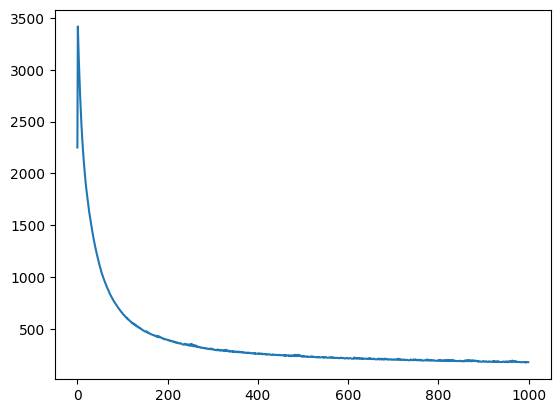

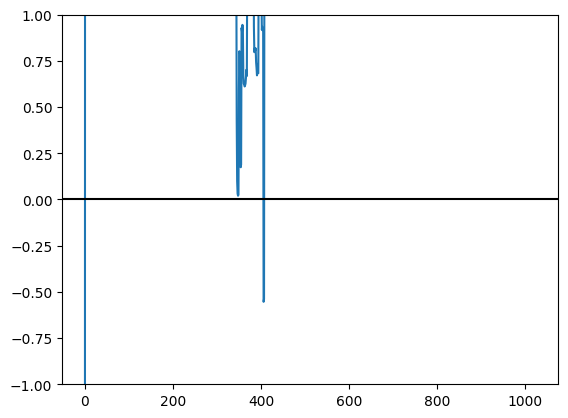

In [4]:
probe_econ, losses_econ = train_probe_on_residuals(resid_activations_econ, activation_coef=0.1)

import matplotlib.pyplot as plt
plt.plot(losses_econ)
plt.show()


feature_values = list(probe_econ(resid_activations_econ).detach().cpu())

feature_values = [x.item() for x in feature_values]

# plot the feature values
import matplotlib.pyplot as plt
plt.plot(feature_values)
# plot x axis
plt.axhline(y=0, color='k')
plt.ylim(-1, 1)
plt.show()



# tokens should be a list of strings
colored_tokens(tokens=model.to_str_tokens(econ_text)[1:], values=feature_values[1:])


In [5]:

# import datetime
# timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# probe_name = f"starts_high_finsih_low_probe_{timestamp}.pth"
# torch.save(probe_econ.state_dict(), probe_name)


Cool, we can learn stable-ish features by the looks! How doees this feature behave on another text dataset, lets say a random text and an unrealted prompt?

In [6]:
HTML1 = vis_probe_activations_on_random_tokens(len_random_tokens=100, model=model, layer_index=10, probe=probe_econ)

HTML1


In [7]:
misc_prompt = """Žinoma, štai trumpas anekdotas lietuviškai:

Mokytoja klausia: – Petriuk, kodėl tavo namų darbai nepadaryti? Petriukas atsako: – Nes mano šuo suvalgė sąsiuvinį!

Tikiuosi, kad patiko!
"""

HTML2 = vis_probe_activations_on_string(misc_prompt, model=model, layer_index=10, probe=probe_econ)

HTML2


### Results

So our feature seems more "stable" on the text on which it is trained I guess, thats cool, however it also activates often on random tokens and a lithuanian joke. It's not exactly sparsely activating.

### Next

Demonstrate that there are even stable features in random text

100%|██████████| 1000/1000 [00:00<00:00, 1828.45it/s]


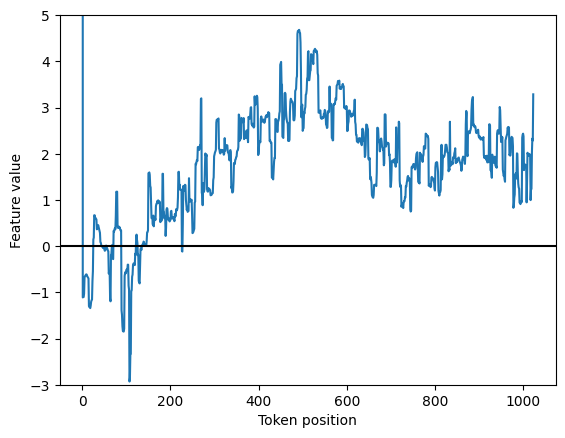

In [8]:
random_tokens = torch.randint(0, 50256, (1, 3000))
random_string = model.to_string(random_tokens)[0]
resid_random = string_to_residual_stream(random_string, model, layer_index=10)

probe_trained_on_rand_text, losses = train_probe_on_residuals(resid_random, activation_coef=0.1)

# import matplotlib.pyplot as plt
# plt.plot(losses)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Loss curve for the probe")
# plt.show()

feature_values = list(probe_trained_on_rand_text(resid_random).detach().cpu())

feature_values = [x.item() for x in feature_values]

# plot the feature values
import matplotlib.pyplot as plt
plt.plot(feature_values)
# plot x axis
plt.axhline(y=0, color='k')
plt.xlabel("Token position")
plt.ylabel("Feature value")
plt.ylim(-3, 5)
plt.show()


colored_tokens(tokens=model.to_str_tokens(random_string)[1:], values=feature_values[1:])



In [9]:
HTML = vis_probe_activations_on_random_tokens(
    len_random_tokens=100,
    model=model,
    layer_index=10,
    probe=probe_trained_on_rand_text
)

HTML

### results

There are learnable stable directions even in random features but these are not stable in other random text. Uh, ok. Maybe the takeaway is there are some stable features in resid stream for all prompts, but these differ prompt to prompt. Some sort of path-dependent thing maybe, like first 2 tokens were x therefore that will be represented in the text forever (stable) but in another prompt this direction will take much more random values.

Overall this is negative, because it raises the quetion about whether our learned features on econ text are meaningful, probably worth just checking using anthropic style feature interptretation!

In [14]:
from datasets import load_dataset
import datasets

ds = load_dataset("ola13/small-the_pile")
print(type(ds))

<class 'datasets.dataset_dict.DatasetDict'>


In [31]:
import torch

def get_highest_activating_contexts(
    model: transformer_lens.HookedTransformer,
    probe: nn.Module,
    ds: datasets.dataset_dict.DatasetDict,
    layer_index: int,
    num_contexts: int,
    context_size: int = 10
):
    contexts_with_features = []

    for i, paragraph in enumerate(ds["train"]["text"]):
        tokens = model.to_tokens(paragraph)
        resid_activations = model.run_with_cache(tokens, stop_at_layer=layer_index+1)[1]["resid_post", layer_index]
        feature_values = probe(resid_activations).detach().cpu().squeeze()

        max_activation, max_index = torch.max(feature_values, dim=0)

        # Get context around the max activating token
        start = max(0, max_index - context_size)
        end = min(len(tokens[0]), max_index + context_size + 1)
        context_tokens = tokens[0][start:end]
        context_text = model.to_string(context_tokens)
        context_features = feature_values[start:end].tolist()

        contexts_with_features.append((context_text, context_features, max_activation.item()))

        if i % 100 == 0:
            print(f"Processed {i} paragraphs")

        if i >= 1000:
            break

    # Sort contexts based on their maximum activation value
    contexts_with_features.sort(key=lambda x: x[2], reverse=True)

    # Get the top num_contexts
    top_contexts = contexts_with_features[:num_contexts]

    # Separate the contexts and their feature values
    highest_activating_contexts = [c[0] for c in top_contexts]
    features_for_each_context = [c[1] for c in top_contexts]

    return highest_activating_contexts, features_for_each_context



highest_activating_paragraphs, features = get_highest_activating_contexts(
    model=model, probe=probe_trained_on_rand_text, ds=ds, layer_index=10, num_contexts=10
)

Processed 0 paragraphs
Processed 100 paragraphs
Processed 200 paragraphs
Processed 300 paragraphs
Processed 400 paragraphs
Processed 500 paragraphs
Processed 600 paragraphs
Processed 700 paragraphs
Processed 800 paragraphs
Processed 900 paragraphs
Processed 1000 paragraphs


In [45]:
import numpy as np
from IPython.display import HTML, display
from transformers import BertTokenizer

def get_color(value):
    r = min(255, int(max(0, value) * 255))
    b = min(255, int(max(0, 1 - value) * 255))
    return f'rgb({r},0,{b})'

def create_interactive_sentence(tokens, values):
    token_value_pairs = [{'token': token, 'value': float(value)} for token, value in zip(tokens, values)]
    
    html_content = f"""
    <div id="interactive-sentence" style="line-height: 2.5em; position: relative;"></div>
    <script>
        var tokenData = {token_value_pairs};
        var container = document.getElementById('interactive-sentence');
        
        tokenData.forEach(function(item, index) {{
            var span = document.createElement('span');
            span.textContent = item.token + ' ';
            span.style.backgroundColor = `rgb(${{Math.min(255, Math.max(0, item.value * 255))}},0,${{Math.min(255, Math.max(0, (1 - item.value) * 255))}})`;
            span.style.padding = '3px 0';
            span.style.margin = '0 1px';
            span.style.borderRadius = '3px';
            span.style.cursor = 'pointer';
            span.style.position = 'relative';
            span.style.zIndex = '1';
            
            var tooltip = document.createElement('div');
            tooltip.textContent = item.value.toFixed(3);
            tooltip.style.position = 'absolute';
            tooltip.style.backgroundColor = 'black';
            tooltip.style.color = 'white';
            tooltip.style.padding = '2px 5px';
            tooltip.style.borderRadius = '3px';
            tooltip.style.fontSize = '0.8em';
            tooltip.style.display = 'none';
            tooltip.style.zIndex = '2';
            
            span.appendChild(tooltip);
            
            span.onmouseover = function(e) {{
                this.style.outline = '2px solid rgba(0,0,0,0.5)';
                tooltip.style.display = 'block';
                var rect = this.getBoundingClientRect();
                var containerRect = container.getBoundingClientRect();
                tooltip.style.top = (rect.top - containerRect.top - tooltip.offsetHeight - 5) + 'px';
                tooltip.style.left = (rect.left - containerRect.left) + 'px';
            }};
            span.onmouseout = function() {{
                this.style.outline = 'none';
                tooltip.style.display = 'none';
            }};
            
            container.appendChild(span);
            if ((index + 1) % 15 === 0) {{
                container.appendChild(document.createElement('br'));
            }}
        }});
    </script>
    """
    
    display(HTML(html_content))

def tokenize_and_visualize(text, model_name='bert-base-uncased'):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    encoded = tokenizer.encode_plus(text, add_special_tokens=False)
    tokens = tokenizer.convert_ids_to_tokens(encoded['input_ids'])
    
    # Generate random values for demonstration
    values = np.random.rand(len(tokens))
    
    create_interactive_sentence(tokens, values)

# Test the function
sample_text = "Transformers have revolutionized natural language processing tasks. They have become the go-to solution for various NLP problems, offering state-of-the-art performance across a wide range of applications. From sentiment analysis to machine translation, transformers have shown remarkable adaptability and effectiveness."
tokenize_and_visualize(econ_text)


Token indices sequence length is longer than the specified maximum sequence length for this model (1177 > 512). Running this sequence through the model will result in indexing errors


In [12]:
# print average length of the text
total_len = 0
# for text in ds['train']['text']:
#     total_len += len(text)

# average_len = total_len / len(ds['train']['text'])



Below is some code that will be used for testing causal interventions on found features. Lets leave this for later

In [ ]:
def resid_ablation_hook(
    value,
    hook
):
    
    # add the vector from the probe to the resid stream

    steering_vector = probe_trained_on_rand_text.linear.weight.T
    value = value + einsum("bph,h->bph", value, steering_vector)

    return value

text_2_tokens = model.to_tokens(text2)

fwd_hooks = [(model.transformer.resid_post, resid_ablation_hook)]

# Run the model with hooks and get the logits
with torch.no_grad():
    logits = model.run_with_hooks(
        text_2_tokens, 
        return_type="logits", 
        fwd_hooks=fwd_hooks
    )

# Get the token completion
predicted_tokens = torch.argmax(logits, dim=-1)

# Convert tokens back to text
completed_text = model.to_string(predicted_tokens[0])

print("Completed text:", completed_text)
        



AttributeError: 'HookedTransformer' object has no attribute 'transformer'